In [1]:
import os, sys, glob
import json, csv, re, datetime
import pickle
import collections
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import cm as cm
from tqdm import tqdm
from collections import Counter

from dir_build_dataset_tweets import read_vids

In [2]:
# filter criterion: video must have last-day viewcount of 270+
# vidsfile    = "/home/users/u6314203/pyProject/hip-popularity/data/engage16/filtered/vids_filter_all.csv"
# tweets_dataset_base = "/localdata/u6314203/dataset_tweets"
vidsfile    = "C:/Users/u6314203/pyProjects/hip-popularity/data/engage16/filtered/vids_filter_all.csv"
tweets_dataset_base = "G:/MLCV dataset/engagement'16/tweets_dataset_fixTZ"
engage_dataset_base = "G:/MLCV dataset/engagement'16/tweeted_videos"

categories_eligible = ["autos", "comedy","education","entertainment", \
                       "film","gaming","howto","music",\
                       "news","people","science","sports",\
                       "travel"]

In [3]:
engage_vids = read_vids(vidsfile)
tweets_vids = collections.defaultdict(list)

print("Num. videos in 'tweets engage'/'engage16'")
for category in categories_eligible[:]:
    tweetsFile = os.path.join(tweets_dataset_base, "{}.json".format(category))
    with open(tweetsFile, "r") as f:
        tweetsData = json.load(f)
    exists, total  = 0, len(engage_vids[category])
    for vid, _ in tweetsData.items():
        if vid in engage_vids[category]:
            tweets_vids[category].append(vid)
            exists += 1
            
    print("{}: {}/{}".format(category, exists, total))

Num. videos in 'tweets engage'/'engage16'
autos: 25597/25712
comedy: 31678/31741
education: 41005/41191
entertainment: 179517/180128
film: 42954/43101
gaming: 221470/222236
howto: 60796/61027
music: 117764/118094
news: 38082/38249
people: 221975/222658
science: 32148/32278
sports: 39537/39649
travel: 13043/13112


#### Profile each category

In [4]:
def engage_days(test_category, eval_days = [90, 135, 180, 225, 270]):
    # read days info in engage16
    with open(os.path.join(engage_dataset_base, test_category+".json"), "r") as f:
        dataset_json = f.readlines()

    # dict-like dataset
    dataset = {}
    # attributes
    vids_set = set()

#     for line in tqdm(dataset_json, desc="{} in engage".format(test_category)):
    for line in dataset_json:
        record = json.loads(line)
        try:        
            day = [int(x) for x in record['insights']['days'].split(",")]
            day_zero = record['insights']['startDate']

            """!!!"""
            if len(day) < eval_days[-1]: continue
        except:
            continue
        dataset[record['id']] = (day_zero, day)

        if record['id'] in vids_set:
            continue
        vids_set.add(record['id'])
        
    return dataset

def tweets_days(test_category):
    with open(os.path.join(tweets_dataset_base, test_category+".json"), "r") as f:
        dataset_json = f.readlines()
        
    dataset = json.loads(dataset_json[0])
    return dataset        

In [5]:
def get_diff_tweets_vs_engage(test_category, engage_dataset, tweets_dataset):    
    diff_tweetsToEngage = {
        "vids": [],
        "day_zero": [],
        "last_day": [],
        "length": []
    }
    
    for vid in tweets_dataset.keys():
        diff_tweetsToEngage["vids"].append(vid)
        record1 = tweets_dataset[vid]['day_zero'], tweets_dataset[vid]['days']
        record2 = engage_dataset[vid]    

        diff_tweetsToEngage["day_zero"].append((datetime.datetime.strptime(record1[0], "%Y-%m-%d") 
                                        - datetime.datetime.strptime(record2[0], "%Y-%m-%d")).days)

        diff_tweetsToEngage["last_day"].append(record1[1][-1] - record2[1][-1])
        diff_tweetsToEngage["length"].append(len(record1[1]) - len(record2[1]))
    return diff_tweetsToEngage

In [8]:
cmap = cm.get_cmap('RdYlBu_r')

def display_diff(test_category, diff_tweetsToEngage, save_base='figs/tmp/'):
    Cnt = Counter(diff_tweetsToEngage["day_zero"])
    most_common_diff = [
        [diff for diff, _ in Cnt.most_common(10)], 
        [cnt  for _, cnt in Cnt.most_common(10)], 
        ["{:.3f}".format(cnt/len(diff_tweetsToEngage['vids'])) for diff, cnt in Cnt.most_common(10)]
    ]    
    
    df = pd.DataFrame(most_common_diff[1:], columns = most_common_diff[0])
    print("Top 10 difference at `day_zero` ({})".format(test_category))
    display(df)
    
    # fig1: last_day
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    bin_width = 50
    bins = [x for x in range(min(diff_tweetsToEngage["last_day"])//bin_width*bin_width,
                             max(diff_tweetsToEngage["last_day"])//bin_width*bin_width+bin_width, bin_width)]
    ax.hist(diff_tweetsToEngage["last_day"], rwidth=0.9, bins=bins, log=True)
    ax.set_ylim(bottom=1)
    ax.set_xticks(bins)
    ax.set_title("`last_day` difference between tweets-engage and engage16 ({})".format(test_category))
    ax.set_xlabel("`last_day` difference")
    ax.set_ylabel("Num. videos (log)")
    plt.savefig(save_base+"last_day({}, logY)".format(test_category))
    
    # fig2: length
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    bin_width = 50
    bins = [x for x in range(min(diff_tweetsToEngage["length"])//bin_width*bin_width,
                             max(diff_tweetsToEngage["length"])//bin_width*bin_width+bin_width, bin_width)]
    ax.hist(diff_tweetsToEngage["length"], rwidth=0.9, bins=bins, log=True)
    ax.set_ylim(bottom=1)
    ax.set_xticks(bins)
    ax.set_title("`length` difference between tweets-engage and engage16 ({})".format(test_category))
    ax.set_xlabel("`length` difference")
    ax.set_ylabel("Num. videos (log)")
    plt.savefig(save_base+"length({}, logY)".format(test_category))
    

#### Problem
1. <s>tweets max 61 days, engage max ~400 days</s>
2. <s>diff_day_zero should not be negative</s> -> user at Youtube can modify publish date
3. <s>In `date`.bz2 file, there can be tweets in both `date`-1 and `date`</s> -> use `created_at` field
4. tweets data are worse missing in last day and length
    - Most videos have 250-300 less records of tweets compared to engage

autos stats done
comedy stats done
education stats done
entertainment stats done
film stats done
gaming stats done
howto stats done
music stats done
news stats done
people stats done
science stats done
sports stats done
travel stats done
Top 10 difference at `day_zero` (all_cats)


,0,1,2,3,4,5,6,7,8,9
0,791863,91410,25075,15873,12121,9997,8751,7413,6223,5678
1,0.743,0.086,0.024,0.015,0.011,0.009,0.008,0.007,0.006,0.005


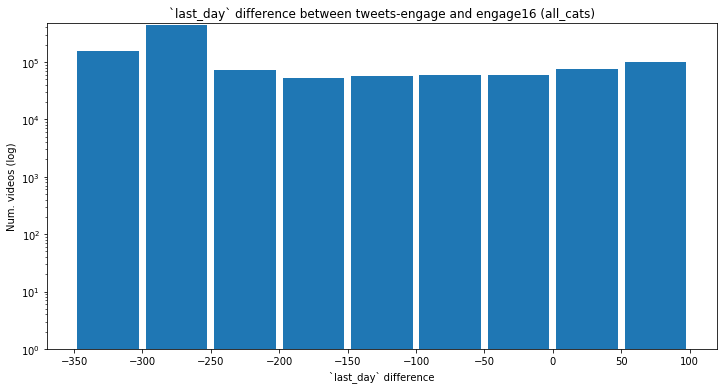

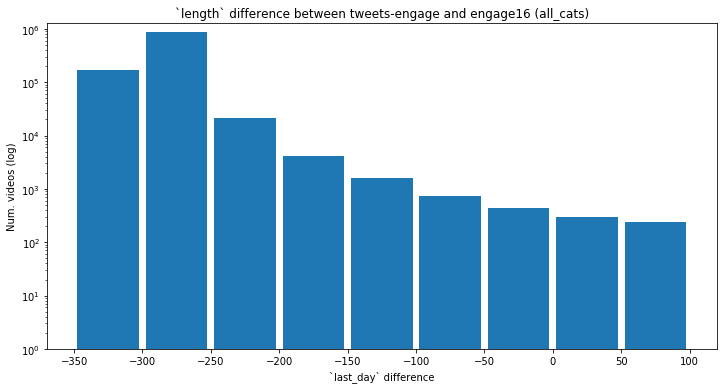

In [10]:
# all categories
diff = {
    "vids": [],
    "day_zero": [],
    "last_day": [],
    "length": []
}

for test_category in categories_eligible[:]:
    engage_dataset = engage_days(test_category)
    tweets_dataset = tweets_days(test_category)
        
    diff_tweetsToEngage = get_diff_tweets_vs_engage(test_category, engage_dataset, tweets_dataset)
    
    for key in diff.keys():
        diff[key] = diff[key] + diff_tweetsToEngage[key]
    print(test_category, "stats done")
    
display_diff("all_cats", diff, save_base="figs/diff_tweets-engage_engage16/")

Top 10 difference at `day_zero` (autos)


,0,1,2,3,4,5,6,7,8,10
0,18483,2621,705,449,279,216,211,167,144,134
1,0.722,0.102,0.028,0.018,0.011,0.008,0.008,0.007,0.006,0.005


Top 10 difference at `day_zero` (comedy)


,0,1,2,3,4,5,6,8,7,10
0,24161,2442,672,415,307,273,256,224,214,171
1,0.763,0.077,0.021,0.013,0.010,0.009,0.008,0.007,0.007,0.005


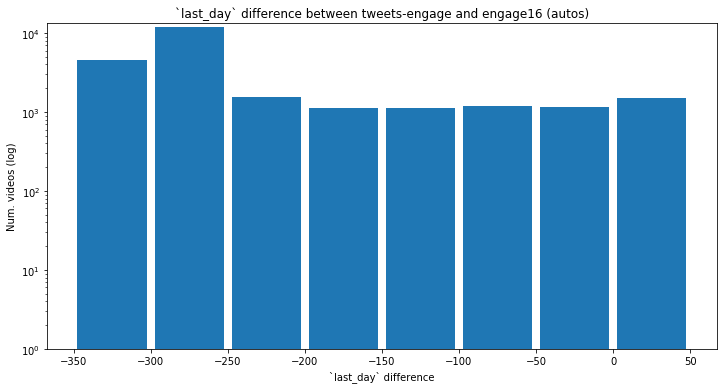

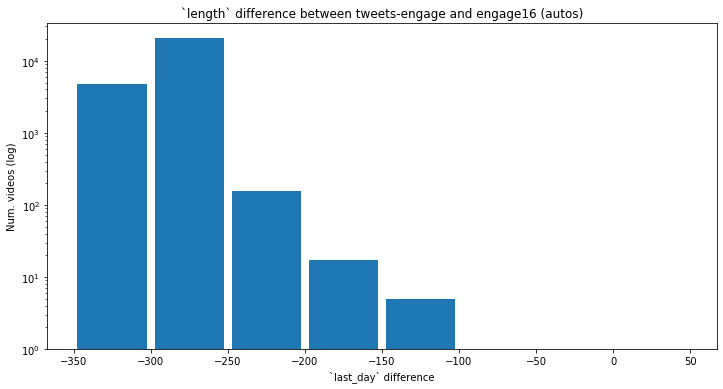

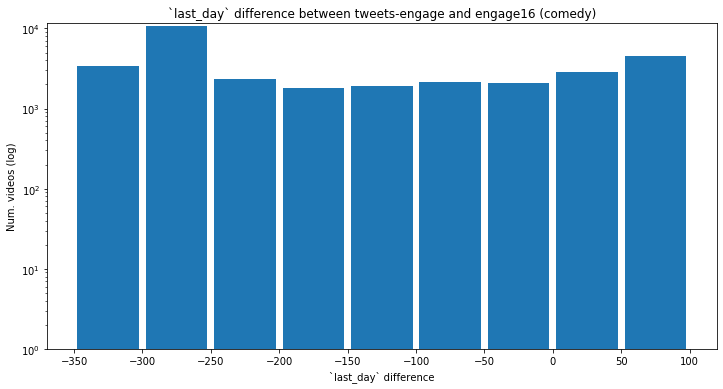

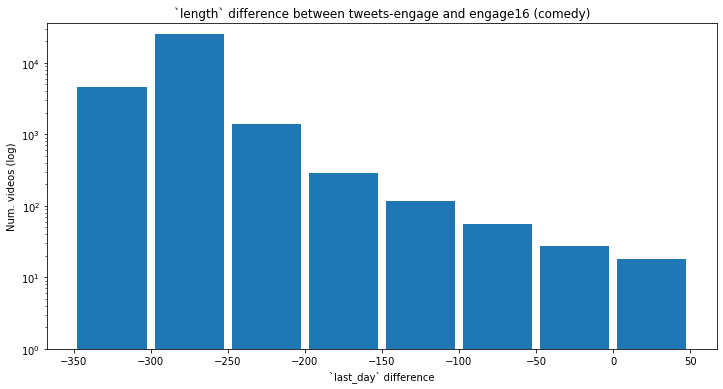

In [9]:
# by category
for test_category in categories_eligible[:]:
    engage_dataset = engage_days(test_category)
    tweets_dataset = tweets_days(test_category)
        
    diff_tweetsToEngage = get_diff_tweets_vs_engage(test_category, engage_dataset, tweets_dataset)
    
    display_diff(test_category, diff_tweetsToEngage, save_base = "figs/diff_tweets-engage_engage16/")